<a href="https://colab.research.google.com/github/rurounigit/EasyOCR/blob/master/easyocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import os

In [15]:
import json

In [16]:
import numpy as np # Import numpy

In [17]:
from PIL import Image, ImageDraw # Import Image and ImageDraw from PIL

In [18]:
image_folder = 'drive/MyDrive/easyocr'  # Replace with your folder path

In [19]:
!pip install easyocr

In [20]:
# Create a reader to do OCR.
# If you change to GPU instance, it will be faster. But CPU is enough.
# (by MENU > Runtime > Change runtime type > GPU, then redo from beginning )
import easyocr
reader = easyocr.Reader(['en'])

In [21]:

# Draw bounding boxes
def draw_boxes(image, bounds, color='yellow', width=2):
    draw = ImageDraw.Draw(image)
    for bound in bounds:
        p0, p1, p2, p3 = bound[0]
        draw.line([*p0, *p1, *p2, *p3, *p0], fill=color, width=width)
    return image




In [22]:
# Draw predefined bounding boxes
def draw_boxes_custom(image, boxes, color='yellow', width=2):
    draw = ImageDraw.Draw(image)
    for box in boxes:
        draw.line([*box[0], *box[1], *box[2], *box[3], *box[0]], fill=color, width=width)
    return image

In [23]:
# Convert NumPy int64 to native Python int before serialization
def convert_to_json_serializable(obj):
    """
    Recursively converts NumPy int64 to Python int in a nested dictionary or list.
    """
    if isinstance(obj, np.int64):
        return int(obj)  # Convert int64 to int
    elif isinstance(obj, list):
        return [convert_to_json_serializable(item) for item in obj]
    elif isinstance(obj, tuple):  # Added to handle tuples
        return tuple(convert_to_json_serializable(item) for item in obj)  # Convert tuples recursively
    elif isinstance(obj, dict):
        return {key: convert_to_json_serializable(value) for key, value in obj.items()}
    else:
        return obj

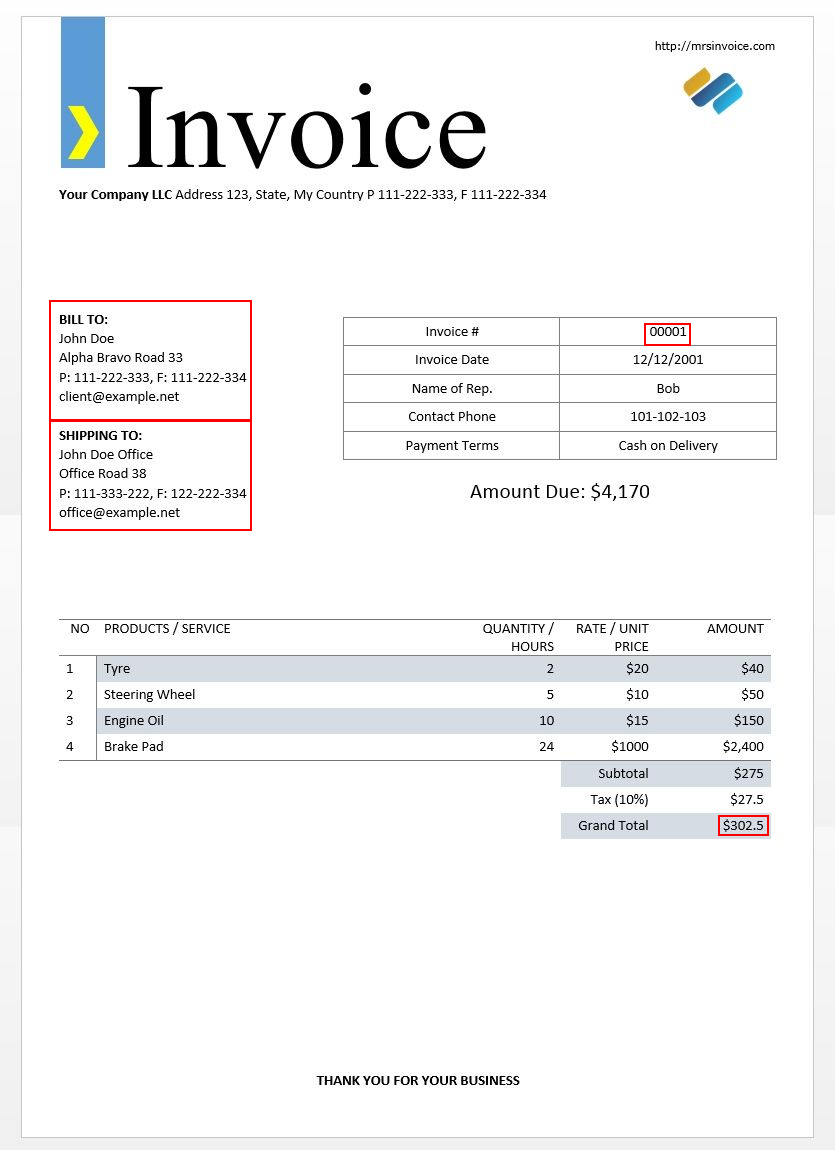

In [29]:

# Define the 4x4 coordinate pairs for the boxes
box01 = [(50, 300), (250, 300), (250, 420), (50, 420)]
box02 = [(50, 420), (250, 420), (250, 530), (50, 530)]
box03 = [(645, 323), (689, 323), (689, 345), (645, 345)]
box04 = [(719, 815), (767, 815), (767, 835), (719, 835)]

#draw defined boxes on first image
# Get the first image file
first_image_file = next(f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', '.jpeg')))
first_image_path = os.path.join(image_folder, first_image_file)

# Open the first image
im = Image.open(first_image_path)

# Now you can use draw_boxes correctly
im = draw_boxes_custom(im, [box01, box02, box03, box04], color='red', width=2)

# Display or save the image with the boxes
display(im)  # To display the image in Colab
#im.save("drive/MyDrive/easyocr/output/first_image_with_boxes.jpg")  # To save the image



# Function to check if a box is inside another box
def is_inside(box, container):
    # Assuming boxes are defined by top-left and bottom-right corners
    # Adjust the logic if your boxes are defined differently
    box_x1, box_y1 = box[0][0], box[0][1]  # Top-left corner of box
    box_x2, box_y2 = box[2][0], box[2][1]  # Bottom-right corner of box
    container_x1, container_y1 = container[0][0], container[0][1]  # Top-left corner of container
    container_x2, container_y2 = container[2][0], container[2][1]  # Bottom-right corner of container

    return (
        container_x1 <= box_x1
        and container_y1 <= box_y1
        and container_x2 >= box_x2
        and container_y2 >= box_y2
    )

In [25]:

simplified_results_all_images = {}  # Initialize before the loop


In [26]:

for filename in os.listdir(image_folder):
    if filename.endswith(('.jpg', '.png', '.jpeg')):
        image_path = os.path.join(image_folder, filename)
        im = Image.open(image_path)
        bounds = reader.readtext(image_path, paragraph=False, detail=1, text_threshold=0.7, low_text=0.3)
        #draw_boxes(im, bounds).save(f"drive/MyDrive/easyocr/output/output_{filename}") # to save image
        #display(im) # to show images

        # Process OCR results for the current image
        filtered_results = {
            "box01": [],
            "box02": [],
            "box03": [],
            "box04": [],
        }

        for bound in bounds:
            box = bound[0]
            for box_name in filtered_results:
                if is_inside(box, globals()[box_name]):
                    filtered_results[box_name].append(bound)

        filtered_results_serializable = convert_to_json_serializable(filtered_results)

        # Simplify results for the current image
        simplified_results = {}
        for box_name, bounds_list in filtered_results_serializable.items():
            simplified_results[box_name] = []
            for bound in bounds_list:
                simplified_results[box_name].append(bound[1])

        # Store simplified results for the current image in the overall dictionary
        simplified_results_all_images[filename] = simplified_results



In [27]:

# Display the dictionary in pretty JSON format
print(json.dumps(simplified_results_all_images, indent=4))


{
    "invoice-sample.jpg": {
        "box01": [
            "BILL TO:",
            "John Doe",
            "Alpha Bravo Road 33",
            "P: 111-222-333,F: 111-222-334",
            "client@example net"
        ],
        "box02": [
            "SHIPPING TO:",
            "John Doe Office",
            "Office Road 38",
            "P: 111-333-222,F: 122-222-334",
            "office@example net"
        ],
        "box03": [
            "OO001"
        ],
        "box04": [
            "S302.5"
        ]
    },
    "invoice-sample2.jpg": {
        "box01": [
            "BILL TO:",
            "John Doe",
            "Alpha Bravo Road 33",
            "P: 111-222-333,F: 111-222-334",
            "client@example net"
        ],
        "box02": [
            "SHIPPING TO:",
            "John Doe Office",
            "Office Road 38",
            "P: 111-333-222,F: 122-222-334",
            "office@example net"
        ],
        "box03": [
            "OO001"
        ],
        